In [1]:
# import libraries
import pandas as pd
import numpy as np
import pickle5 as pickle
import math
import matplotlib.pyplot as plt
from matplotlib import colors

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

from helpers import *
import time

#### Prepare raw data
- Create detect and classify labels 
- Add ID from index for identifying specific wafers

In [2]:
# load data
with open('WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)
print(f'Raw data shape: {raw_data.shape}')
raw_data.head()

Raw data shape: (172950, 11)


,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train


In [3]:
# add index column to identify specific wafers 
raw_data.reset_index(inplace=True)
raw_data = raw_data.rename(columns={'index':'ID'})

# add detection model labels
raw_data['detectLabels'] = raw_data['failureType'].apply(lambda x: 0 if x == 'none' else 1)

# add classification model labels
fail_dict = {'none': 8, 'Loc': 0, 'Edge-Loc': 1, 'Center': 2, 'Edge-Ring': 3, 
             'Scratch': 4, 'Random': 5, 'Near-full': 6, 'Donut': 7}
raw_data['classifyLabels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])

raw_data.head()

,ID,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detectLabels,classifyLabels
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8


#### Create 224x224 thinned datasets (n=2, 4)
- waferMap resized to 224x224 then binarized --> binaryMap
- n=2,4 thinning applied --> thinMap2 and thinMap4

In [4]:
# resize to 224x224 and binarize
start = time.time()

def preprocess(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    ret, thresh_img = cv2.threshold(new_y, 1, 1, cv2.THRESH_BINARY)
    return thresh_img
    
raw_data['binaryMap'] = raw_data.waferMap.apply(lambda x: preprocess(x))

# check that resizing worked
walltime = time.time() - start
print(f'Time: {walltime:.3f} seconds')
print(raw_data.binaryMap[2].shape)
print(np.unique(raw_data.binaryMap[2]))

Time: 326.202 seconds
(224, 224)
[0 1]


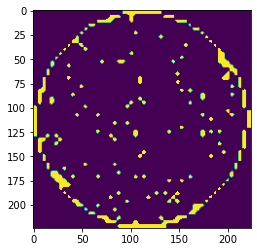

In [5]:
plt.imshow(raw_data.binaryMap[23135])

In [6]:
# apply thinning n=2
start = time.time()

raw_data['thinMap2'] = raw_data.binaryMap.apply(lambda x: thin(x, 2))

walltime = time.time() - start
print(f'Time: {walltime:.3f} seconds')

Time: 548.134 seconds


In [7]:
# apply thinning n=4
start = time.time()

raw_data['thinMap4'] = raw_data.binaryMap.apply(lambda x: thin(x, 4))

walltime = time.time() - start
print(f'Time: {walltime:.3f} seconds')

Time: 1054.287 seconds


In [9]:
np.unique(raw_data.thinMap4[23135])

array([False,  True])

In [18]:
# change thinMap columns to uint8
raw_data['thinMap2'] = raw_data.thinMap2.apply(lambda x: x.astype(np.uint8))
raw_data['thinMap4'] = raw_data.thinMap4.apply(lambda x: x.astype(np.uint8))

In [19]:
# keep only columns needed for modeling
model_data = raw_data[['ID', 'thinMap2', 'thinMap4', 'dataset', 'detectLabels', 'classifyLabels']]
model_data.head()

# split model data into train, dev, and test sets
model_train = model_data[model_data.dataset == 'train'].reset_index(drop=True)
model_dev = model_data[model_data.dataset == 'dev'].reset_index(drop=True)
model_test = model_data[model_data.dataset == 'test'].reset_index(drop=True)
print(f"Train: {len(model_train)}")
print(f"Dev: {len(model_dev)}")
print(f"Test: {len(model_test)}")

Train: 121065
Dev: 25942
Test: 25943


[0 1]


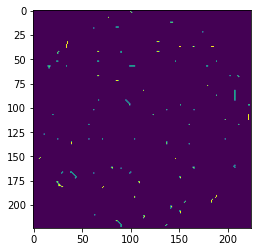

In [20]:
# sanity check
trial = model_data.thinMap2[0]
print(np.unique(trial))
plt.imshow(trial)

In [21]:
# save dev and test sets, keeping only needed columns
model_dev2 = model_dev.drop(['dataset', 'thinMap4'], axis=1)
with open('WM-clean224-thin2-dev.pkl', "wb") as f:
    pickle.dump(model_dev2, f)

model_dev4 = model_dev.drop(['dataset', 'thinMap2'], axis=1)
with open('WM-clean224-thin4-dev.pkl', "wb") as f:
    pickle.dump(model_dev4, f)

model_test2 = model_test.drop(['dataset', 'thinMap4'], axis=1)
with open('WM-clean224-thin2-test.pkl', "wb") as f:
    pickle.dump(model_test2, f)

model_test4 = model_test.drop(['dataset', 'thinMap2'], axis=1)
with open('WM-clean224-thin4-test.pkl', "wb") as f:
    pickle.dump(model_test4, f)

# sanity check
model_dev2.head()

,ID,thinMap2,detectLabels,classifyLabels
0,15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,8
1,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0
2,24,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,8
3,30,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,8
4,35,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1


In [22]:
# create detund dataset
# make list of none indices
none_df = model_train[model_train.detectLabels == 0]
none_list = none_df.index.tolist()
print(f'None count: {len(none_list)}')

# make list of defect indices
def_df = model_train[model_train.detectLabels == 1]
def_list = def_df.index.tolist()
print(f'Defect count: {len(def_list)}')

# randomly undersample none list
from random import sample, seed
seed(424)
under_none = sample(none_list, 30000)

# recombine defect indices with undersampled none indices
new_list = sorted(under_none + def_list)
print(f'Undersampled dataset count: {len(new_list)}')

# undersample data
undersampled = model_train.iloc[new_list].reset_index(drop=True)
print(undersampled.shape)
undersampled.head()

None count: 103202
Defect count: 17863
Undersampled dataset count: 47863
(47863, 6)


,ID,thinMap2,thinMap4,dataset,detectLabels,classifyLabels
0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,0,8
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,1,1
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,1,1
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,1,1
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,1,0


In [23]:
# save undersampled dataset, keeping only needed columns
undersampled2 = undersampled.drop(['dataset', 'classifyLabels', 'thinMap4'], axis=1)
with open('WM-clean224-thin2-train-detund.pkl', "wb") as f:
    pickle.dump(undersampled2, f)
    
undersampled4 = undersampled.drop(['dataset', 'classifyLabels', 'thinMap2'], axis=1)
with open('WM-clean224-thin4-train-detund.pkl', "wb") as f:
    pickle.dump(undersampled4, f)

# sanity check
undersampled2.head()

,ID,thinMap2,detectLabels
0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [24]:
# create classify dataset (not augmented)
classify = model_train[model_train.detectLabels == 1].reset_index(drop=True)
classify = classify.drop(['dataset', 'detectLabels'], axis=1)

# sanity check
print(f'Label range: {classify.classifyLabels.unique()}')
print(f'Number of rows: {len(classify)}')

Label range: [1 0 2 6 5 4 3 7]
Number of rows: 17863


In [25]:
# save classify dataset
classify2 = classify.drop('thinMap4', axis=1)
with open('WM-clean224-thin2-train-classify.pkl', "wb") as f:
    pickle.dump(classify2, f)
    
classify4 = classify.drop('thinMap2', axis=1)
with open('WM-clean224-thin4-train-classify.pkl', "wb") as f:
    pickle.dump(classify4, f)
    
# sanity check
classify2.head()

,ID,thinMap2,classifyLabels
0,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
1,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,41,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [26]:
# create knn sanitized dataset
# load IDs of samples correctly classified by KNN
with open('knn_sanitize_ids.pkl', "rb") as fh:
    knn = pickle.load(fh)
print(f'KNN length: {len(knn)}')
knn[:3]

KNN length: 15030


[36, 37, 38]

In [27]:
# subset classify dataset
# get indices corresponding to IDs
correct_indices = [classify.index[classify.ID == i][0] for i in knn]

knn_data = classify.loc[correct_indices].reset_index(drop=True)

print(knn_data.shape)
knn_data.head()

(15030, 4)


,ID,thinMap2,thinMap4,classifyLabels
0,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
1,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,43,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2


In [28]:
# save knn sanitized dataset
knn_data2 = knn_data.drop('thinMap4', axis=1)
with open('WM-clean224-thin2-train-knn.pkl', "wb") as f:
    pickle.dump(knn_data2, f)
    
knn_data4 = knn_data.drop('thinMap2', axis=1)
with open('WM-clean224-thin4-train-knn.pkl', "wb") as f:
    pickle.dump(knn_data4, f)